In [1]:
pip install git+https://github.com/MIROptics/ECC2025.git

  Cloning https://github.com/MIROptics/ECC2025.git to /tmp/pip-req-build-wqc8128a
  Running command git clone --filter=blob:none --quiet https://github.com/MIROptics/ECC2025.git /tmp/pip-req-build-wqc8128a
  Resolved https://github.com/MIROptics/ECC2025.git to commit e31eb6f432a48fb0dba88ab733432da967ef05ee
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/

In [2]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from ECC2025.testing import test_3a, test_3b, test_3c

### Algoritmo de Shor

El **algoritmo de Shor** es uno de los algoritmos cuánticos más conocidos. Publicado en 1994 por Peter Shor en su artículo [Algorithms for Quantum Computation: Discrete Logarithms and Factoring](https://doi.org/10.1109%2Fsfcs.1994.365700), su importancia recae en su utilidad para factorizar, ya sea números primos u otras estructuras que poseen estructura similar,  y **resolver el problema del logaritmo discreto en un tiempo polinomial**, una mejora considerable del tiempo subexponencial de los mejores algoritmos clásicos. Como los protocolos criptográficos de clave pública más utilizados actualmente (RSA, Diffie-Hellman, Curvas elípticas) están basados en la dificultad de resolver el problema del logaritmo discreto en computadores clásicos, si se llegara poder implementar el algoritmo de Shor en una cantidad considerable de qubits, estos protocolos criptográficos quedarían obsoletos.

La cantidad necesaria aproximada para romper una clave RSA de 2048 bits con el algoritmo de Shor es de 4000 qubits lógicos, una cantidad que sin tener corrección de errores se ve difícil de alcanzar en el corto plazo, aún así las empresas de ciberseguridad y gobiernos están proponiendo cambios y nuevas estandarizaciones para hacer frente a la posibilidad de poder implementarlo.

### Transformada Cuántica de Fourier

La subrutina más importante del algoritmo de Shor es el algoritmo de estimación de fase, y para implementar este algoritmo, primero necesitamos la **transformada cuántica de Fourier** (QFT, Quantum Fourier Transform). La QFT es la versión cuántica de la **transformada discreta de Fourier**, que actúa sobre los amplitudes de probabilidad de un estado cuántico. Esta operación permite transformar un estado cuántico de tal manera que las frecuencias de las componentes de la superposición puedan ser extraídas con mayor facilidad.

Matemáticamente, la transformada cuántica de Fourier para un estado cuántico $|x\rangle$ de $n$ qubits es una superposición de los estados $|y\rangle$, dada por la expresión:
\begin{equation}
|x\rangle \mapsto \frac{1}{\sqrt{2^n}} \sum_{y=0}^{2^n - 1} e^{2\pi i \frac{xy}{2^n}} |y\rangle,
\end{equation}

Lo que está representado por el siguiente circuito:

![circuit](https://raw.githubusercontent.com/MIROptics/ECC2025/refs/heads/master/desafios/img/ECC25_QFT.png?raw=true)

Como nuestro objetivo final es implementar el algoritmo de estimación de fase, comenzaremos creando una función para implementar la transformada cuántica de Fourier.

__Desafío:__ Cree una función llamada ``Fourier(n)`` cuyo argumento es el número de qubits $n$ y que retorne el circuito cuántico de la transformada de Fourier de $n$ qubits.

In [102]:
def Fourier(n):
    """
    n : Numero de qubits
    """
    qc = QuantumCircuit(n)

    ## Escribe tu codigo acá ###

    for i in range(n-1, 0, -1 ):
      qc.h(i)
      count = 1
      for j in range(i, -1, -1):
        if (j!= i):
          qc.cp(theta = np.pi/(2**(count)), control_qubit=i, target_qubit=j)
          count +=1
    qc.h(0)

    for i in range(n//2):
      qc.swap(i, n-1-i)

    ######

    return qc


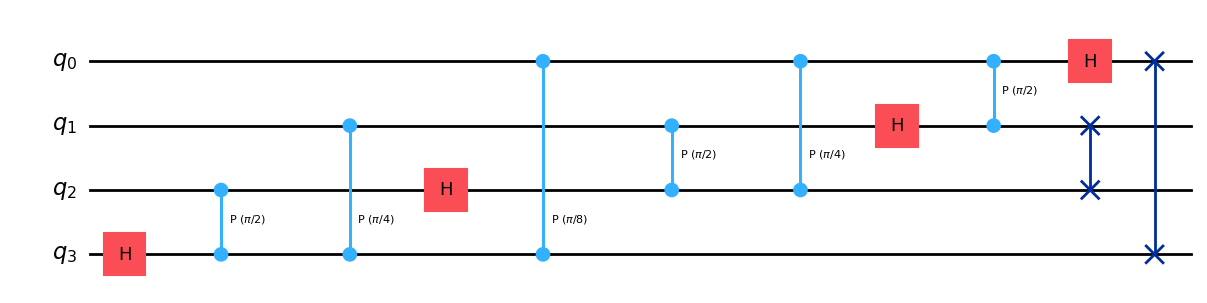

In [103]:
qc = Fourier( 4 )
qc.draw('mpl')

In [104]:
test_3a( Fourier )

Felicidades, tu solución es correcta!


### Potencia de una operación unitaria

En concreto, la transformada cuántica de Fourier es utilizada por el algoritmo de estimación de fase para estimar una fase codificada en una **operación unitaria** $U$. El algoritmo necesita aplicar potencias de $U$ en la forma $U^{m}$  para poder extraer la información de la fase con precisión. Estas potencias permiten construir una superposición que, cuando se combina con la QFT, revela la fase asociada a un autovector de $U$.

Crearemos ahora la función que construye $U^{m}$ con un $\phi$ especifico para poder utilizarla en nuestra implementación más adelante.

__Desafío:__ Complete la siguiente función para que implente el circuito de $U^m$ controlada, donde
\begin{equation}
U = \begin{pmatrix} 1 & 0 \\ 0 & e^{2\pi i\phi} \end{pmatrix},
\end{equation}
con $\phi = 0.375$.

HINT: Busque la puerta cuántica "control-phase".

In [116]:
def U_to_n( power ):
    """
    power : potencia a la que elevar U
    """
    qc = QuantumCircuit( 2 )
    phi = 0.375
    ###
    qc.cp(2*np.pi*phi*power, 0, 1)

    ###
    return qc

In [117]:
test_3b( U_to_n )

Felicidades, tu solución es correcta!


### Algoritmo de estimación de fase

Dada una operación unitaria $U$ y un autovector $|\psi\rangle$, el **algoritmo de estimación de fase** permite estimar con una alta precisión la fase $\phi$ asociada al autovalor de $|\psi\rangle$, es decir $\phi$ tal que:
\begin{equation}
U|\psi\rangle=e^{2\pi i\phi}|\psi\rangle.
\end{equation}

El proceso consiste en:


1.   Preparar un sistema de $n$ qubits auxiliares en estado de superposición y un qubit en el estado $|\psi\rangle$.
2.   Aplicar las potencias de la operación unitaria, $U^{m}$, a $|\psi\rangle$ de forma controlada para codificar la fase en los qubits auxiliares.
3. Ejecutar la transformada cuántica de Fourier inversa en los qubits auxiliares.
4. Medir los qubits auxiliares para obtener el resultado binario que nos dará la estimación de la fase $\phi$.

Ahora, como anteriormente ya creamos la función para implementar la QFT y $U^{m}$, llegó el momento de implementar el algoritmo de estimación de fase para nuestro caso particular de $\phi$.



__Desafío:__ Utilice las funciones anteriores para completar la siguiente función que implementa el algoritmo de estimación de fase, es decir, el siguiente circuito. Note que IQFT es la operación inversa de la transformada de Fourier.

![circuito](https://raw.githubusercontent.com/MIROptics/ECC2025/refs/heads/master/desafios/img/ECC25_QPE.png?raw=true)

In [126]:
def QuantumPhaseEstimation( n ):
    """
    n : Numero de qubits
    """
    qc = QuantumCircuit( n+1, n )

    ########
    for i in range(n):
      qc.h(i)
    qc.x(n)
    phi = 0.375
    for i in range(n):
      for j in range(2**i):
        qc.cp(2*np.pi*phi, i, n)

    fourier = Fourier(n)

    qc.compose(fourier.inverse(), inplace = True)

    #######
    qc.measure( range(n), range(n) )

    return qc


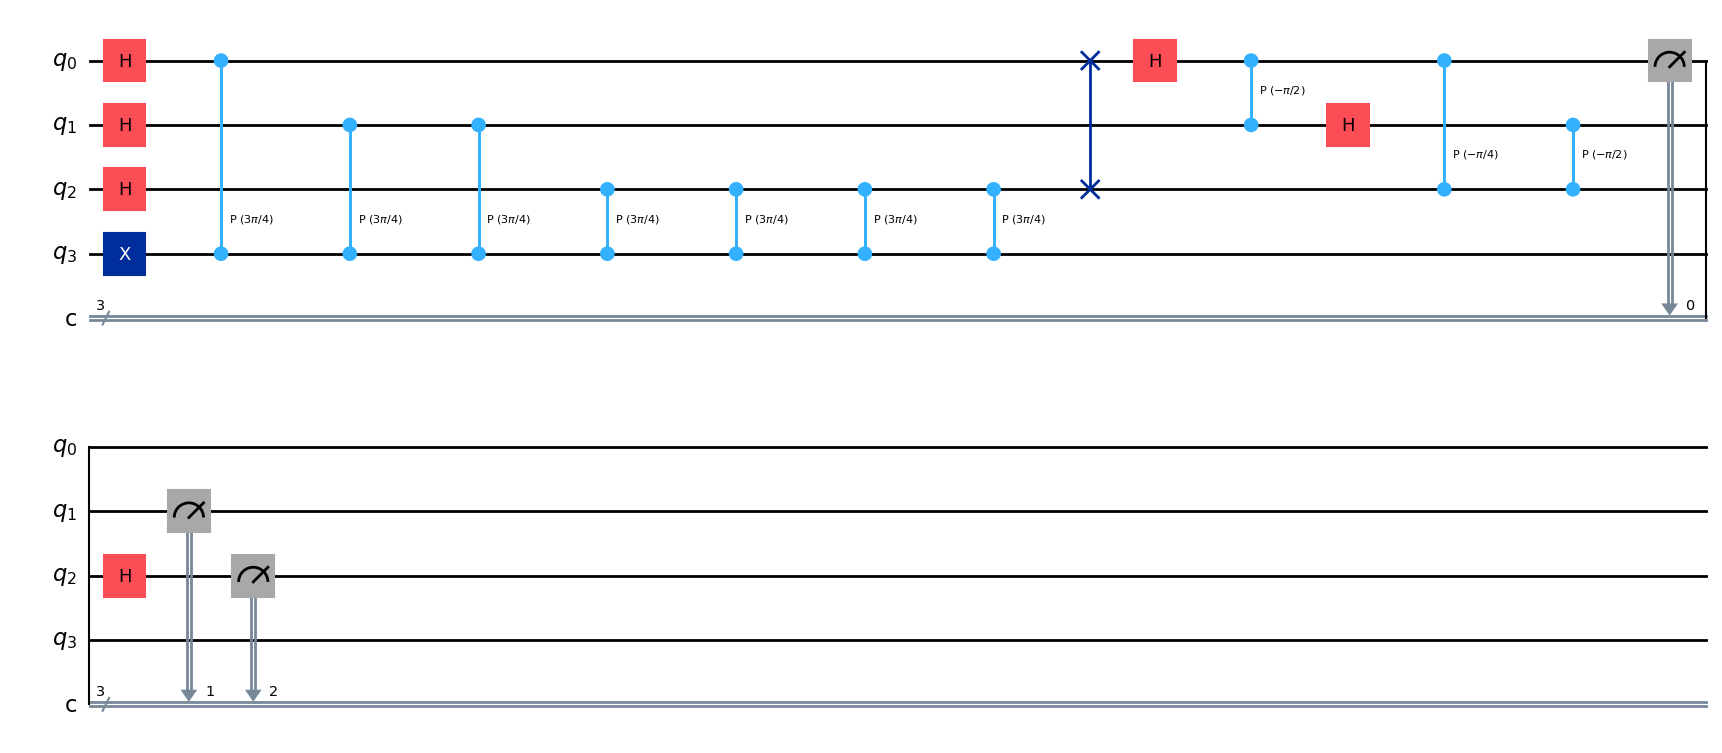

In [127]:
qc = QuantumPhaseEstimation(3)
qc.draw('mpl')

Si sus funciones están correctas, al simular la ejecucción del circuito se debería obtener el resultado $0110\cdots0$ con mayor probabilidad, para un número de qubits $n\geq 3$. Esto es porque el ángulo estimado por el algoritmo es
\begin{equation}
    \tilde\phi = \frac{\text{Int}(0110\cdots0)}{2^n} = \frac{2^{n-2}+2^{n-3}}{2^n} = 0.375
\end{equation}

que es el $\phi$ que utilizamos cuando creamos la función para obtener $U^{m}$.

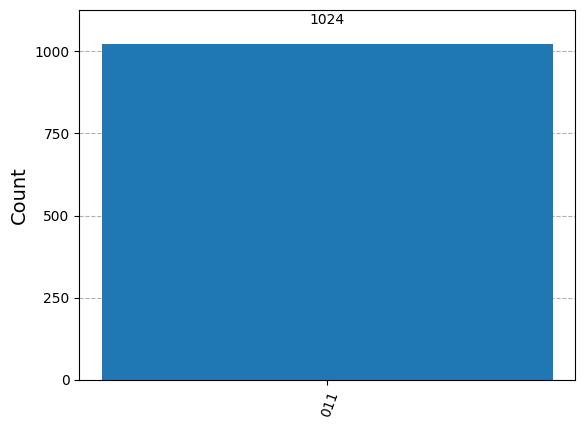

In [128]:
backend = AerSimulator()
job = backend.run( qc )
counts = job.result().get_counts()
plot_histogram( counts )

In [129]:
test_3c( QuantumPhaseEstimation )

Felicidades, tu solución es correcta!
